In [1]:
save_name = 'ResNet34_Oversample_L2_Sum_PosWeight_5_Targets _Thresholds'

In [2]:
import sys
import os, os.path

sys.path.append(os.path.join(os.getcwd() ,'/modules'))
root_path = "C:/git/Springboard-Public/Capstone Project 2/"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/My Drive/Capstone Project 2/"

print('Current Working Dir: ', os.getcwd())
print('Root Path: ', root_path)

# We need to set the working directory since we are using relative paths from various locations
if os.getcwd() != root_path:
  os.chdir(root_path)

Current Working Dir:  C:\git\Springboard-Public\Capstone Project 2\notebooks\ModelRuns
Root Path:  C:/git/Springboard-Public/Capstone Project 2/


In [3]:
from modules.lib.StandardTraining import *
from modules.models.ResNet import ResNet_GrayScale

from torchsummary import summary

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

%matplotlib inline

In [4]:
force_cpu = True
device = torch.device('cuda' if ~force_cpu and torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

Working on device=cuda


In [5]:
training_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural_Effusion']
target_thresholds = [.2, .5, .4, .3, .5]
out_channels=len(training_columns)
net_kwargs = {'layers':34, 'drop_out_precent':.5, 'out_channels':out_channels} #18, 34, 50, 101, 152
net = ResNet_GrayScale(**net_kwargs) 

net = nn.DataParallel(net)
net.to(device)


summary(net, (1, 320, 320))   

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 160]           3,136
       BatchNorm2d-2         [-1, 64, 160, 160]             128
              ReLU-3         [-1, 64, 160, 160]               0
         MaxPool2d-4           [-1, 64, 80, 80]               0
            Conv2d-5           [-1, 64, 80, 80]          36,864
       BatchNorm2d-6           [-1, 64, 80, 80]             128
              ReLU-7           [-1, 64, 80, 80]               0
            Conv2d-8           [-1, 64, 80, 80]          36,864
       BatchNorm2d-9           [-1, 64, 80, 80]             128
             ReLU-10           [-1, 64, 80, 80]               0
       BasicBlock-11           [-1, 64, 80, 80]               0
           Conv2d-12           [-1, 64, 80, 80]          36,864
      BatchNorm2d-13           [-1, 64, 80, 80]             128
             ReLU-14           [-1, 64,

          Linear-125                 [-1, 1000]         513,000
          ResNet-126                 [-1, 1000]               0
          Linear-127                    [-1, 5]           5,005
ResNet_GrayScale-128                    [-1, 5]               0
Total params: 21,796,405
Trainable params: 21,796,405
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.39
Forward/backward pass size (MB): 196.51
Params size (MB): 83.15
Estimated Total Size (MB): 280.05
----------------------------------------------------------------


In [6]:
standardTraining = StandardTraining(number_images=0, 
                                     batch_size=64, 
                                     learning_rate=1e-5, 
                                     num_epochs=4,
                                     device=device, 
                                     net=net,
                                     use_positivity_weights=True,
                                     observation_min_count=150,
                                     loss_reduction='sum',
                                     l2_reg=1e-1,
                                     target_columns=training_columns,
                                     target_thresholds=target_thresholds,
                                     augPercent=.4,
                                     save_path= f'notebooks/saved/{save_name}/',
                                     net_name = 'ResNet_GrayScale',
                                     net_kwargs = net_kwargs)

Total Oversampled Rows Added to Train: 1,302

Number of Training Images: 106,831
Number of Validation Images: 26,219

Positive Weights used in BCEWithLogitsLoss:


Atelectasis          5.123524
Cardiomegaly         7.307878
Consolidation       12.983115
Edema                3.236635
Pleural_Effusion     1.936531
dtype: float64

In [7]:
standardTraining.train()

▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Epoch [1/4]
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
Epoch Loss: 563879.6365         
Time of Completion: 2020-07-31 14:41:36.118194          
Training Duration: 0:18:22.491505          
Validation Duration: 0:02:06.267175

TRAINING

▔▔▔▔▔


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,17446,93197,0.917288,0.171712,0.289273,0.543144,0.178289
1,Cardiomegaly,12859,78251,0.885994,0.145596,0.250093,0.649602,0.188099
2,Consolidation,7640,76551,0.844110,0.084244,0.153199,0.612959,0.099088
3,Edema,25216,87054,0.924254,0.267719,0.415178,0.618787,0.300899
4,Pleural_Effusion,36380,50135,0.662782,0.480941,0.557406,0.705188,0.528784



VALIDATION

▔▔▔▔▔▔▔


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,4080,21189,0.877696,0.169003,0.283430,0.535841,0.162389
1,Cardiomegaly,2966,18454,0.904922,0.145443,0.250607,0.692997,0.209650
2,Consolidation,1550,20077,0.901290,0.069582,0.129190,0.640008,0.088436
3,Edema,6072,22744,0.982213,0.262223,0.413937,0.573484,0.251277
4,Pleural_Effusion,9006,14551,0.798024,0.493918,0.610180,0.755568,0.586581


▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Epoch [2/4]
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
Epoch Loss: 524451.1548         
Time of Completion: 2020-07-31 15:02:08.374616          
Training Duration: 0:18:24.139162          
Validation Duration: 0:02:07.643528

TRAINING

▔▔▔▔▔


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,17446,73154,0.725553,0.173032,0.279426,0.529024,0.171405
1,Cardiomegaly,12859,70475,0.867175,0.158226,0.267622,0.692238,0.221152
2,Consolidation,7640,67357,0.842408,0.095551,0.171634,0.669903,0.121848
3,Edema,25216,81498,0.898517,0.278007,0.424630,0.597859,0.271961
4,Pleural_Effusion,36380,48915,0.729577,0.542615,0.622358,0.771518,0.610765



VALIDATION

▔▔▔▔▔▔▔


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,4080,17375,0.677696,0.159137,0.257749,0.508250,0.154282
1,Cardiomegaly,2966,17266,0.879973,0.151164,0.258007,0.706965,0.223045
2,Consolidation,1550,17963,0.878065,0.075767,0.139497,0.661921,0.098598
3,Edema,6072,21012,0.898221,0.259566,0.402747,0.543358,0.235256
4,Pleural_Effusion,9006,12518,0.774928,0.557517,0.648485,0.797334,0.651009


▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Epoch [3/4]
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
Epoch Loss: 505005.4338         
Time of Completion: 2020-07-31 15:22:36.690469          
Training Duration: 0:18:20.309290          
Validation Duration: 0:02:07.531825

TRAINING

▔▔▔▔▔


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,17446,64113,0.632122,0.172009,0.270430,0.522616,0.168577
1,Cardiomegaly,12859,68327,0.856754,0.161239,0.271401,0.696132,0.227670
2,Consolidation,7640,63014,0.844110,0.102342,0.182552,0.701857,0.151303
3,Edema,25216,77808,0.852316,0.276218,0.417223,0.582222,0.263314
4,Pleural_Effusion,36380,48118,0.754673,0.570576,0.649838,0.801496,0.658548



VALIDATION

▔▔▔▔▔▔▔


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,4080,16479,0.661520,0.163784,0.262561,0.523431,0.158152
1,Cardiomegaly,2966,19680,0.928860,0.139990,0.243310,0.707914,0.227793
2,Consolidation,1550,14113,0.785161,0.086233,0.155398,0.668781,0.100549
3,Edema,6072,19103,0.842721,0.267864,0.406514,0.558400,0.241010
4,Pleural_Effusion,9006,9955,0.691428,0.625515,0.656822,0.813603,0.676050


▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Epoch [4/4]
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
Epoch Loss: 493128.9231         
Time of Completion: 2020-07-31 15:43:06.959567          
Training Duration: 0:18:22.567731          
Validation Duration: 0:02:07.231623

TRAINING

▔▔▔▔▔


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,17446,60462,0.590508,0.170388,0.264466,0.521055,0.169216
1,Cardiomegaly,12859,66683,0.850299,0.163970,0.274924,0.699807,0.224640
2,Consolidation,7640,59820,0.842147,0.107556,0.190750,0.723468,0.183782
3,Edema,25216,76275,0.828720,0.273969,0.411800,0.579968,0.265332
4,Pleural_Effusion,36380,47182,0.760115,0.586092,0.661856,0.814652,0.682947



VALIDATION

▔▔▔▔▔▔▔


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,4080,16116,0.627206,0.158786,0.253417,0.505276,0.153492
1,Cardiomegaly,2966,17301,0.880647,0.150974,0.257759,0.714359,0.235678
2,Consolidation,1550,13190,0.738710,0.086808,0.155360,0.664609,0.094380
3,Edema,6072,15614,0.735507,0.286025,0.411879,0.604010,0.265912
4,Pleural_Effusion,9006,10122,0.703420,0.625864,0.662380,0.819842,0.690548


Training Duration: 1:22:00.081764



TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.110913
Hamming Loss,0.482113
Combined Recall,0.437934
Combined Precision,0.183760
Combined F1,0.245333


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,17446,60462,0.590508,0.170388,0.264466,0.521055,0.169216
1,Cardiomegaly,12859,66683,0.850299,0.163970,0.274924,0.699807,0.224640
2,Consolidation,7640,59820,0.842147,0.107556,0.190750,0.723468,0.183782
3,Edema,25216,76275,0.828720,0.273969,0.411800,0.579968,0.265332
4,Pleural_Effusion,36380,47182,0.760115,0.586092,0.661856,0.814652,0.682947


***** ROC *****


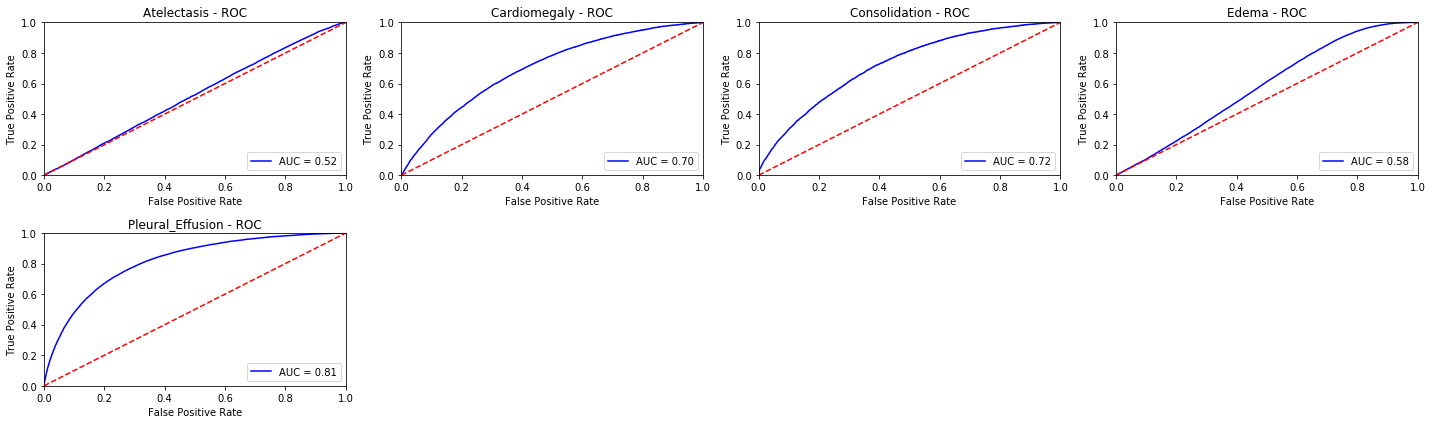

***** Precision / Recall *****


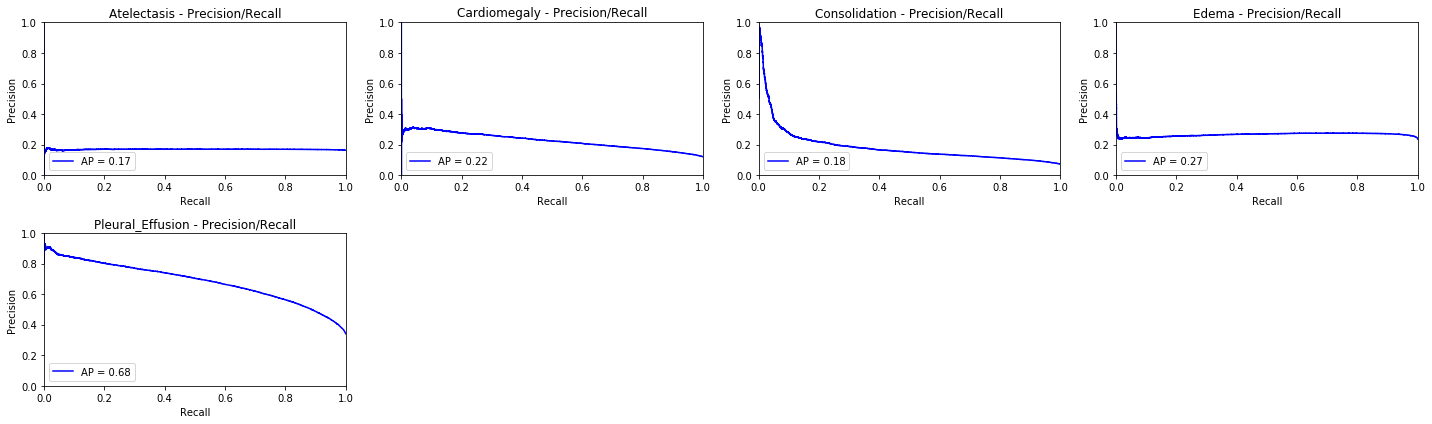


VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.123613
Hamming Loss,0.471284
Combined Recall,0.410528
Combined Precision,0.173419
Combined F1,0.230832


,Target,True Positives,Predicted Positives,Recall,Precision,F1,ROC AUC,Avg Precision
0,Atelectasis,4080,16116,0.627206,0.158786,0.253417,0.505276,0.153492
1,Cardiomegaly,2966,17301,0.880647,0.150974,0.257759,0.714359,0.235678
2,Consolidation,1550,13190,0.738710,0.086808,0.155360,0.664609,0.094380
3,Edema,6072,15614,0.735507,0.286025,0.411879,0.604010,0.265912
4,Pleural_Effusion,9006,10122,0.703420,0.625864,0.662380,0.819842,0.690548


***** ROC *****


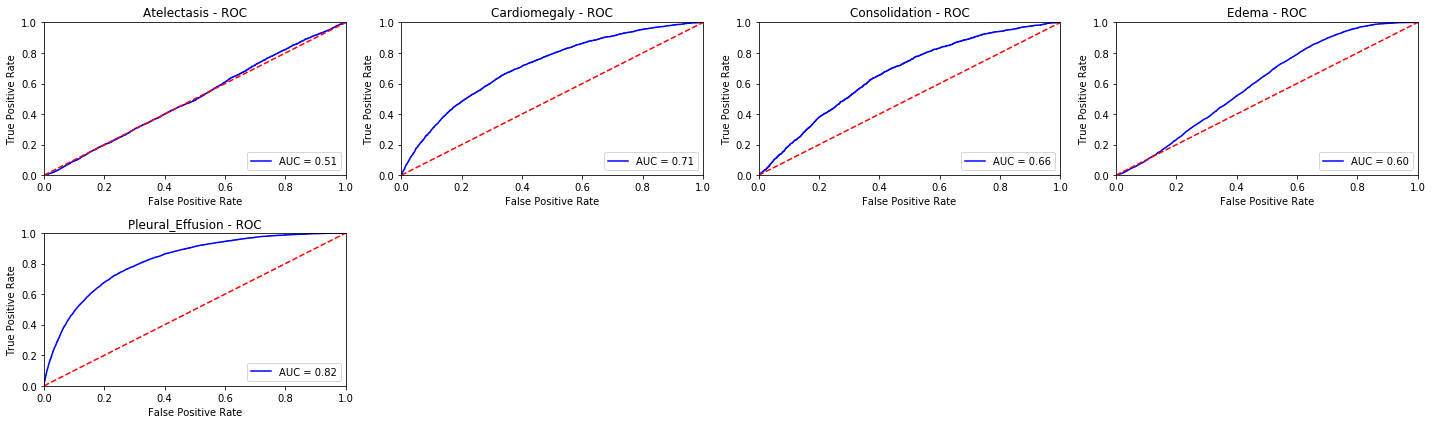

***** Precision / Recall *****


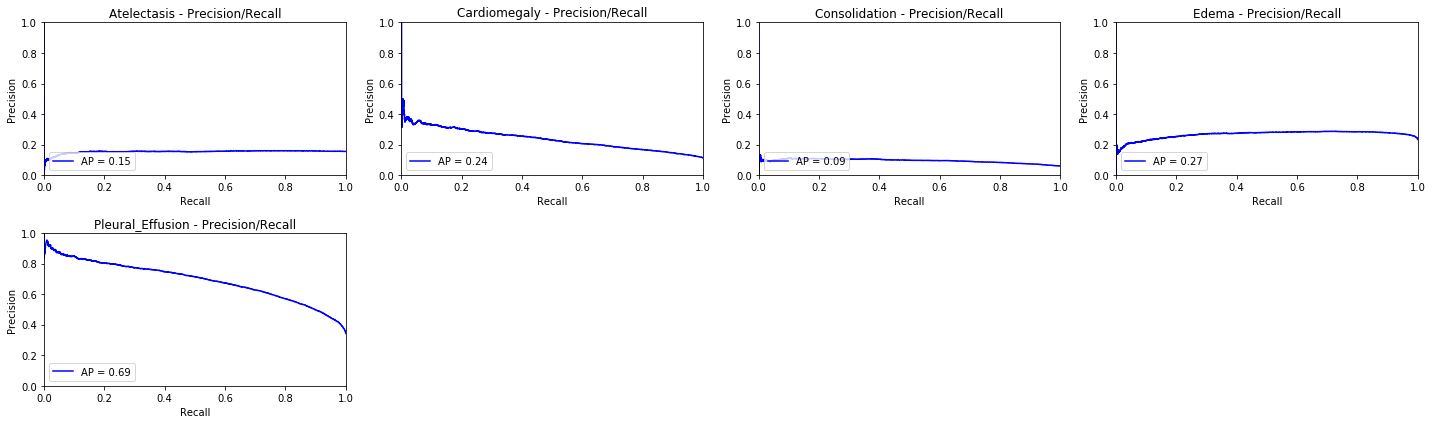

In [8]:
standardTraining.displayMetrics()

In [9]:
standardTraining.displayEpochProgression()

NameError: name 'display_columns' is not defined

In [ ]:
standardTraining.save()